# Automatic Differentiation with Value Class

This notebook implements a simple automatic differentiation engine.


In [5]:
# Re-defining Value with all previous methods PLUS the new ones.
# Copy-paste this entire block.

import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self): return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): return self * other
    
    # --- NEW METHODS BELOW ---
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def __neg__(self): return self * -1
    def __sub__(self, other): return self + (-other)

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

## Example: Compute gradients


In [6]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
e = a * b
d = e + c
f = Value(-2.0)
L = d * f

L.backward()

print(f"L data: {L.data}")
print(f"a grad: {a.grad}")


L data: -8.0
a grad: 6.0


## Visualize the computation graph


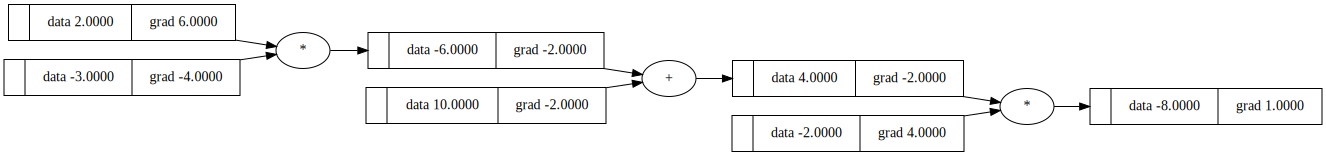

In [7]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # Display label, data, and gradient in the box
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

# Visualize the previous example
draw_dot(L)


In [8]:
import random

class Neuron:
    def __init__(self, nin):
        # Initialize weights and bias with random values
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        # zip pairs input x with weight w
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [9]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [12]:
# 1. Initialize the Network
# 3 inputs, two hidden layers of 4 neurons, 1 output
model = MLP(3, [4, 4, 1])

# 2. Define the Dataset
xs = [[2.0, 3.0, -1.0],
     [3.0, -1.0, 0.5],
     [0.5, 1.0, 1.0],
     [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0] # Desired targets

# 3. Training Loop
learning_rate = 0.05

print("Starting training...")
for k in range(20):
    
    # Forward Pass
    ypred = [model(x) for x in xs]
    loss = sum((yout[0] - ygt)**2 for yout, ygt in zip(ypred, ys))
    
    # Zero Gradients (Critical step!)
    for p in model.parameters():
        p.grad = 0.0
    
    # Backward Pass
    loss.backward()
    
    # Update (Gradient Descent)
    for p in model.parameters():
        p.data += -learning_rate * p.grad
    
    print(f"Step {k}: Loss {loss.data:.4f}")

print("Final Predictions:", [y[0].data for y in ypred])

Starting training...
Step 0: Loss 5.7122
Step 1: Loss 3.2401
Step 2: Loss 2.5421
Step 3: Loss 1.7600
Step 4: Loss 1.0686
Step 5: Loss 0.6175
Step 6: Loss 0.3868
Step 7: Loss 0.2751
Step 8: Loss 0.2102
Step 9: Loss 0.1682
Step 10: Loss 0.1393
Step 11: Loss 0.1182
Step 12: Loss 0.1024
Step 13: Loss 0.0901
Step 14: Loss 0.0802
Step 15: Loss 0.0722
Step 16: Loss 0.0656
Step 17: Loss 0.0600
Step 18: Loss 0.0552
Step 19: Loss 0.0511
Final Predictions: [0.8907629486148853, -0.9111454024087768, -0.8712676828216941, 0.8785577107700739]
